In [7]:
%reload_ext autoreload
%autoreload 2

In [8]:
import pytricia
from nbc_analysis.utils.toml_utils import get_config
from nbc_analysis.utils.file_utils import read_parquet

from pathlib import Path
from toolz import take
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
config = get_config('test')
normalize_cfg = config['normalize']
demographics_cfg = config['demographics']
config

{'demographics': {'demographics_d': '/Users/wmcabee/DATA/NBC/demographics',
  'zip2income_input_f': PosixPath('/Users/wmcabee/_NBC/datasets/ACS_17_5YR_S2503_with_ann.csv'),
  'subnet2zip_input_f': PosixPath('/Users/wmcabee/_NBC/datasets/GeoLite2-City-CSV_20191001.zip')},
 'normalize': {'test_input_d': '/Users/wmcabee/DATA/NBC/work/query',
  'normalize_d': '/Users/wmcabee/DATA/NBC/normalize'}}

In [10]:
indir = Path(normalize_cfg['normalize_d'])
IPS = read_parquet('ips',indir=indir)
IPS

2019-10-22 10:44:58,245|INFO|nbc_analysis.utils.file_utils|start read file,/Users/wmcabee/DATA/NBC/normalize/ips.parquet
2019-10-22 10:44:58,339|INFO|nbc_analysis.utils.file_utils|end read file,/Users/wmcabee/DATA/NBC/normalize/ips.parquet,record_cnt=226596


,ip
0,1.144.107.183
1,1.144.110.127
2,1.144.110.252
3,1.152.111.20
4,1.159.207.45
...,...
226591,99.99.221.220
226592,99.99.240.240
226593,99.99.25.135
226594,99.99.26.73


In [11]:
%time
indir = Path(demographics_cfg['demographics_d'])
SUBNET2INC = read_parquet('subnet2inc.parquet', indir=indir, columns=['network', 'network_key'])
SUBNET2INC.iloc[:10]

2019-10-22 10:44:58,415|INFO|nbc_analysis.utils.file_utils|start read file,/Users/wmcabee/DATA/NBC/demographics/subnet2inc.parquet


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


2019-10-22 10:44:59,097|INFO|nbc_analysis.utils.file_utils|end read file,/Users/wmcabee/DATA/NBC/demographics/subnet2inc.parquet,record_cnt=1243176


,network,network_key
0,2.56.9.245/32,340298234694711661
1,2.56.9.246/32,15967697370209441848
2,2.56.9.247/32,8344275163890935531
3,2.56.9.248/32,17455670536690040679
4,2.56.20.0/22,3447722192060392118
5,2.56.32.0/22,10079855123282555649
6,2.56.44.0/22,5620104867241794362
7,2.56.48.0/22,11967419260617987618
8,2.56.56.0/22,16582982096803622195
9,2.56.114.0/23,12182769773387179504


In [12]:
%%time
PTREE = pytricia.PyTricia(128)

def add_network(rec):
    PTREE.insert(rec.network, rec.network_key)

reader = SUBNET2INC.itertuples()
#reader = take(10000, reader)
reader = map(add_network, reader)
for x in reader: pass

CPU times: user 2.2 s, sys: 89.5 ms, total: 2.29 s
Wall time: 2.29 s


In [13]:
IPS.sample(10)

,ip
87222,2600:2b00:8c06:5100:b911:e0c9:800b:c13e
94967,2600:6c56:6e00:b68:3921:17aa:6fe9:8630
15767,160.3.12.105
226305,99.61.163.142
103631,2601:100:8180:a240:f42c:ff6c:4b56:4b6f
159976,2607:fb90:509b:b5f2:f055:e67d:e8c3:afad
219888,97.119.182.172
124891,2601:644:4201:57c0:c869:4052:cd31:46ff
74475,2600:1700:d4e0:2940:859d:5bcd:ba2c:1ab6
124909,2601:644:4480:2e70:4e17:44ff:feda:9a7f


In [14]:
%%time
def get_network_key(ip):
    return PTREE.get(ip,0)


N = None
df = IPS.sample(N) if N else IPS
df['network_key'] = df.ip.map(get_network_key)

n = len(df)
hits = (df.network_key != 0).sum()
hit_rate = hits/ n
print(f"n={n},hits={hits},hit_rate={hit_rate:.2f}")
HITS = df

n=226596,hits=209735,hit_rate=0.93
CPU times: user 271 ms, sys: 3.21 ms, total: 274 ms
Wall time: 274 ms


In [15]:
df

,ip,network_key
0,1.144.107.183,0
1,1.144.110.127,0
2,1.144.110.252,0
3,1.152.111.20,0
4,1.159.207.45,0
...,...,...
226591,99.99.221.220,5710080146552047293
226592,99.99.240.240,11940849839813756021
226593,99.99.25.135,12793654639833556285
226594,99.99.26.73,12793654639833556285


In [16]:
%%time
indir = Path(demographics_cfg['demographics_d'])
full = read_parquet('subnet2inc.parquet', indir=indir)
full.head()

2019-10-22 10:45:01,948|INFO|nbc_analysis.utils.file_utils|start read file,/Users/wmcabee/DATA/NBC/demographics/subnet2inc.parquet
2019-10-22 10:45:03,061|INFO|nbc_analysis.utils.file_utils|end read file,/Users/wmcabee/DATA/NBC/demographics/subnet2inc.parquet,record_cnt=1243176


CPU times: user 1.44 s, sys: 327 ms, total: 1.77 s
Wall time: 1.11 s


,network_key,ip_type,network,geoname_id,postal_code,latitude,longitude,country_iso_code,country,state_iso_code,state,city,time_zone,geo_id,occup_housing_units,median_household_income,median_household_costs
0,340298234694711661,ip4,2.56.9.245/32,5128581.0,10004,40.7145,-74.0029,US,United States,NY,New York,New York,America/New_York,8600000US10004,1587.0,140450.0,3097.0
1,15967697370209441848,ip4,2.56.9.246/32,4887398.0,60602,41.8483,-87.6517,US,United States,IL,Illinois,Chicago,America/Chicago,8600000US60602,596.0,115774.0,2558.0
2,8344275163890935531,ip4,2.56.9.247/32,4699066.0,77002,29.7720,-95.3644,US,United States,TX,Texas,Houston,America/Chicago,8600000US77002,3295.0,72306.0,1439.0
3,17455670536690040679,ip4,2.56.9.248/32,5368361.0,90009,34.0544,-118.2440,US,United States,CA,California,Los Angeles,America/Los_Angeles,None,NaN,NaN,NaN
4,3447722192060392118,ip4,2.56.20.0/22,5809844.0,98168,47.4902,-122.3004,US,United States,WA,Washington,Seattle,America/Los_Angeles,8600000US98168,11236.0,53992.0,1250.0


In [17]:
%%time
DATA = HITS.merge(full, on='network_key')

CPU times: user 663 ms, sys: 222 ms, total: 884 ms
Wall time: 918 ms


In [18]:
DATA

,ip,network_key,ip_type,network,geoname_id,postal_code,latitude,longitude,country_iso_code,country,state_iso_code,state,city,time_zone,geo_id,occup_housing_units,median_household_income,median_household_costs
0,100.0.0.137,10300813828390822074,ip4,100.0.0.0/24,4952762.0,01876,42.6028,-71.2319,US,United States,MA,Massachusetts,Tewksbury,America/New_York,8600000US01876,11413.0,94817.0,1810.0
1,100.0.0.34,10300813828390822074,ip4,100.0.0.0/24,4952762.0,01876,42.6028,-71.2319,US,United States,MA,Massachusetts,Tewksbury,America/New_York,8600000US01876,11413.0,94817.0,1810.0
2,100.0.10.205,10361118008558753010,ip4,100.0.10.0/24,4952762.0,01876,42.6028,-71.2319,US,United States,MA,Massachusetts,Tewksbury,America/New_York,8600000US01876,11413.0,94817.0,1810.0
3,100.0.103.120,11922969650209609697,ip4,100.0.103.0/24,4930577.0,01821,42.5511,-71.2560,US,United States,MA,Massachusetts,Billerica,America/New_York,8600000US01821,11211.0,99881.0,1721.0
4,100.0.108.127,13409439327975650993,ip4,100.0.108.0/24,4942807.0,01902,42.4684,-70.9465,US,United States,MA,Massachusetts,Lynn,America/New_York,8600000US01902,17154.0,42851.0,1208.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209730,99.99.221.220,5710080146552047293,ip4,99.99.216.0/21,4699066.0,77056,29.7502,-95.4710,US,United States,TX,Texas,Houston,America/Chicago,8600000US77056,10782.0,107003.0,1740.0
209731,99.99.240.240,11940849839813756021,ip4,99.99.240.0/23,4997384.0,49203,42.2290,-84.4132,US,United States,MI,Michigan,Jackson,America/Detroit,8600000US49203,15397.0,42100.0,771.0
209732,99.99.25.135,12793654639833556285,ip4,99.99.24.0/22,4924006.0,47302,40.1684,-85.3807,US,United States,IN,Indiana,Muncie,America/Indiana/Indianapolis,8600000US47302,11410.0,32250.0,597.0
209733,99.99.26.73,12793654639833556285,ip4,99.99.24.0/22,4924006.0,47302,40.1684,-85.3807,US,United States,IN,Indiana,Muncie,America/Indiana/Indianapolis,8600000US47302,11410.0,32250.0,597.0


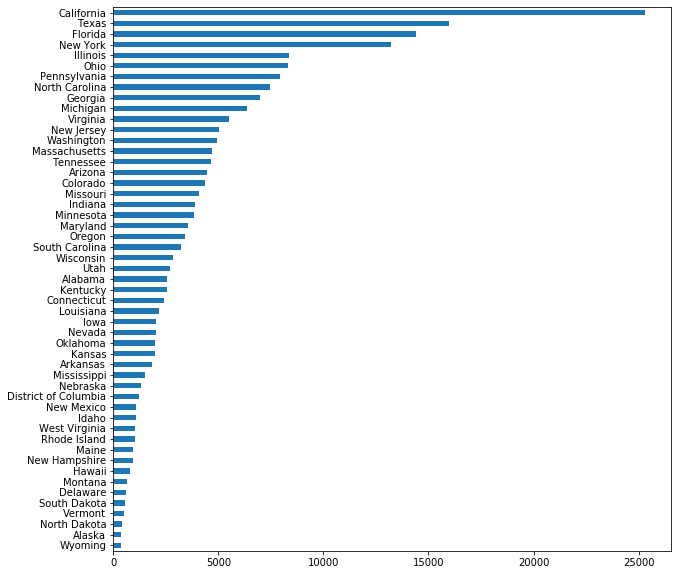

In [19]:
figure = plt.figure(figsize=[10,10])
DATA.state.value_counts(dropna=False).sort_values(ascending=True).plot(kind='barh')

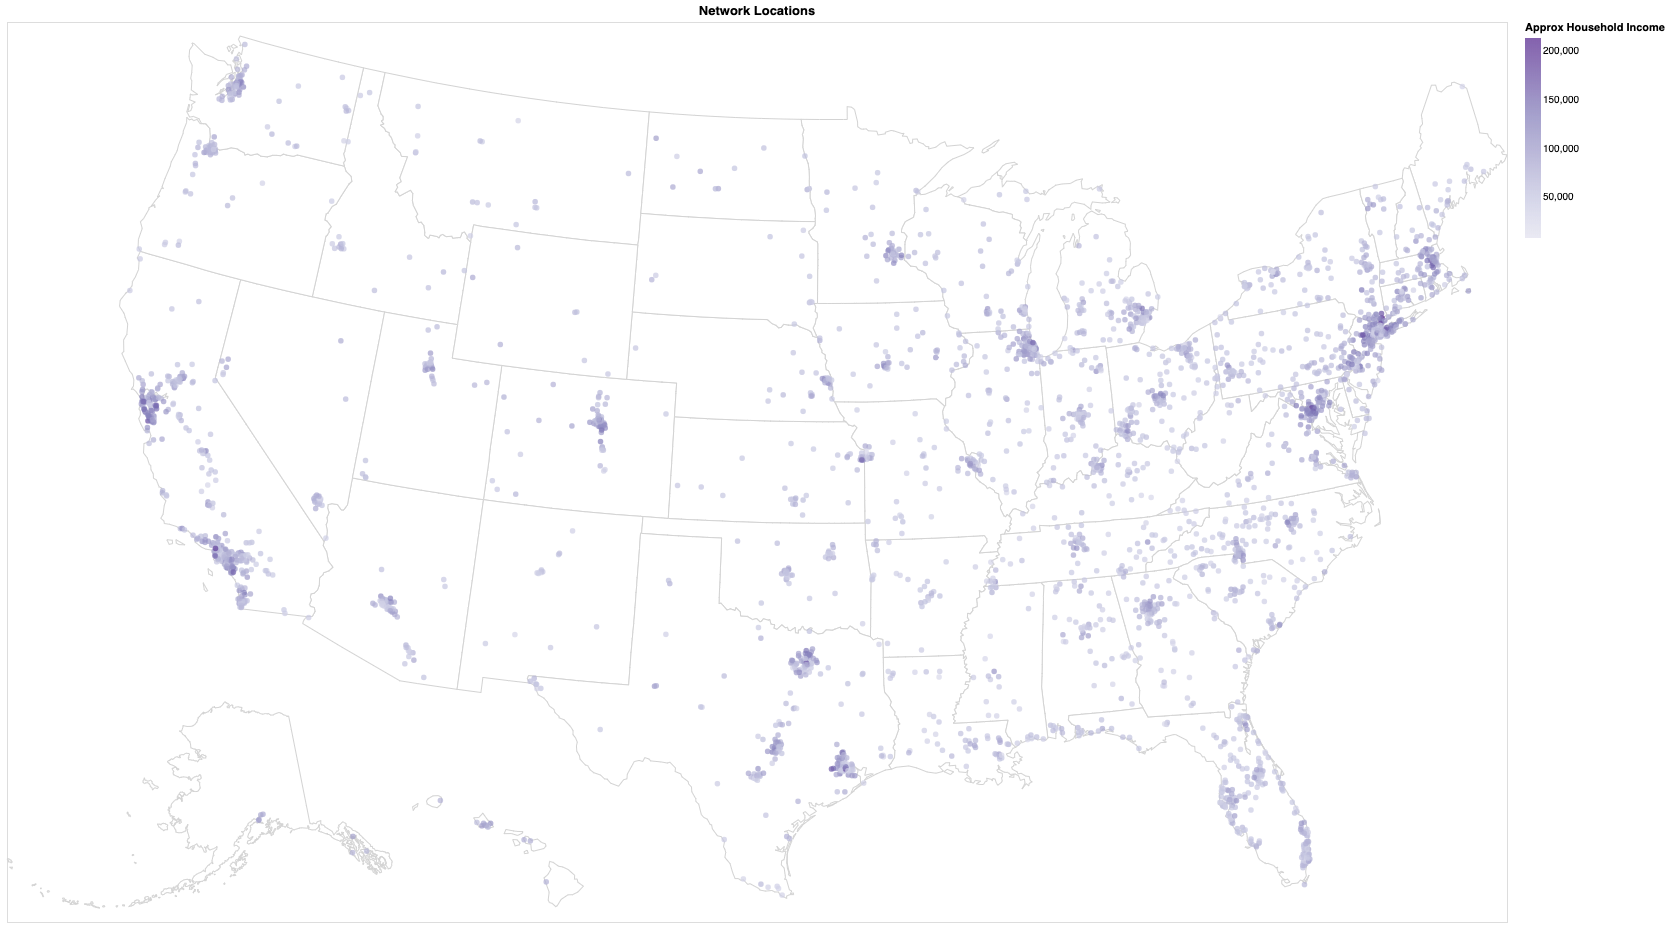

In [21]:
import altair as alt
from vega_datasets import data


states = alt.topo_feature(data.us_10m.url, feature='states')

# US states background
background = alt.Chart(states).mark_geoshape(
    fill='white',
    stroke='lightgrey'
).properties(
    width=1500,
    height=900
).project('albersUsa')

# airport positions on background
#df = DATA[DATA.state_iso_code == 'TX']
df = DATA
points = alt.Chart(df.sample(5000)).transform_aggregate(
    latitude='mean(latitude)',
    longitude='mean(longitude)',
    count='count()',
    income='mean(median_household_income)',
    groupby=['postal_code', 'city', 'state',]
).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    #size=alt.Size('income:Q', title='Approx Household Income'),
    size=alt.value(30),
    color=alt.Color('income:Q', title='Approx Household Income', scale=alt.Scale(scheme="purples")),
    #color=alt.value('steelblue'),
    tooltip=['state:N', 'city:N','postal_code:N', 'count:Q']
).properties(
    title='Network Locations'
)

background + points